# NanoDTC XPS Data Analysis Practical (demonstration)


 ### -------- Table of Contents ----------   <a id="0"></a> 

1. [Using the workbook](#0)   
1. [Introduction to XPS data analysis](#2)
1. [Setting up](#5)     
1. [Binding energy scale calibration](#10) 
1. [Background treatment](#11) 
1. [Basic peak fitting](#12)
1. [Fitting multiplet peaks](#13)
1. [Common errors](#18)



## 1. Using the workbook <a id="0"></a> 

This Jupyter workbook is intended to provide self-contained introductory tutorial on how to process XPS data using Python.

There are a number of commercial data analysis packages for processing XPS data (e.g. CasaXPS). A link to a list of some of them can be found <A Href="https://www.harwellxps.guru/knowledgebase/software/">here</A>. However, being able to write your own data analysis code in a programming language such as Python or Matlab offers several advantages, including (1) greater flexibility, and (2) greater control/understanding over the processing methods that are being applied.

This workbook assumes no prior knowledge of Python (although a degree of familiarity in Python will help in working through the material and adapting it for your own use in future). If this is your first time using this format, all of the Python code is broken down into individual cells. You work through the notebook by running each cell in turn.

<div class="alert alert-block alert-info" style="font-size: 16px;"> 
<b>Tip:</b>  To run cells, click the cell you want to run. Either press <b>Run</b> at the top of the page, or press <b>Shift + Enter</b> together.</div>

## 2. Introduction to XPS data analysis <a id="2"></a> 

### A. Overview of analysis <a id="3"></a>

Analysis of an XPS spectrum is performed by curve fitting, whereby mathematical functions are fit to the various peaks in the spectrum to extract information about their height, width and area. This allows one to infer information such as the chemical composition of a sample (both qualitative and quantitative) and chemical environment of different elements.

Data processing cannot compensate for poor experimental data. The following (non-exhaustive) points/steps are essential to consider to ensure that the data quality is adequate and the collected spectra are suitable for analysis.

- Spectrometer calibration of binding energy scale
- Charge compensation
- Charge referencing
- Checking sample X-ray stability
- Optimising SNR

Provided that the experimental data is sufficiently high quality, we can meaningfully proceed to data analysis. The analysis of spectra typically proceeds via the following steps in sequence:

1. Binding energy scale calibration
2. Background treatment
3. Curve fitting

### B. Additional resources <a id="4"></a>

While self-contained, this workbook only provides the basics on data processing and curve fitting to get you started on analysing XPS spectra. The following publications provide excellent supplementary material on XPS data analysis, and are highly recommended for more in-depth learning of specific topics. Click on each link to access the relevant publication.

- <A Href="https://pubs.aip.org/avs/jva/article/38/6/061203/1023652/Practical-guide-for-curve-fitting-in-x-ray">Practical guide for curve fitting in x-ray photoelectron spectroscopy</A> J. Vac. Sci. Technol. A 38, 061203 (2020)

- <A Href="https://pubs.aip.org/avs/jva/article/38/4/041201/246897/Practical-guides-for-x-ray-photoelectron">Practical guides for x-ray photoelectron spectroscopy: Quantitative XPS</A> J. Vac. Sci. Technol. A 38, 041201 (2020)

- <A Href="https://pubs.aip.org/avs/jva/article/39/1/011201/1025655/Practical-guide-to-the-use-of-backgrounds-in">Practical guide to the use of backgrounds in quantitative XPS</A> J. Vac. Sci. Technol. A 39, 011201 (2021)

- <A Href="https://pubs.aip.org/avs/jva/article-abstract/39/1/013204/246569/Practical-guides-for-x-ray-photoelectron?redirectedFrom=fulltext">Practical guides for x-ray photoelectron spectroscopy (XPS): Intepreting the carbon 1s spectrum</A> J. Vac. Sci. Technol. A 39, 013204 (2021)

- <A Href="https://pubs.aip.org/avs/jva/article/38/3/031204/1063946/XPS-guide-Charge-neutralization-and-binding-energy">XPS guide: Charge neutralization and binding energy referencing for insulating samples</A> J. Vac. Sci. Technol. A 38, 031204 (2020)

- <A Href="https://pubs.aip.org/avs/jva/article-abstract/38/6/063203/1024050/Introductory-guide-to-backgrounds-in-XPS-spectra?redirectedFrom=fulltext">Introductory guide to backgrounds in XPS spectra and their impact on determining peak intensities</A> J. Vac. Sci. Technol. A 38, 063203 (2020)

- <A Href="https://onlinelibrary.wiley.com/doi/full/10.1002/anie.201916000">Compromising Science by Ignorant Instrument Calibration—Need to Revisit Half a Century of Published XPS Data</A> Angew.Chem.Int.Ed.,59, 5002, (2020)


## 3. Setting up <a id="6"></a> 

### A. Importing Python packages <a id="7"></a> 

<div class="alert alert-success" style="font-size: 16px;"> 
<b>Task 0: Run the following code block to import all the necessary Python packages.</b>  <br> <br> If it does not run correctly, try restarting the workbook by pressing <b>Kernel</b>, then <b>Restart & Clear Output</b>. 
</div>

In [1]:
################################# Import all of the necessary Python packages ################################# 
import os
from numpy import genfromtxt 

import pandas as pd  # for storing data as spreadsheet
import numpy as np  # for matrix operations
from matplotlib import pyplot as plt  # for plotting
%matplotlib notebook
from scipy.signal import savgol_filter  # for data smoothing
from scipy.optimize import minimize, curve_fit
from ipywidgets import interact, widgets

### B.  Importing data <a id="8"></a> 

<b> The data </b>

To illustrate the various steps of XPS data analysis, we will be looking at spectra collected from a sample of Na$_2$WO$_{4}$ crystals dispersed on a SiO$_2$ substrate. 

<img src="Fig1 sample.png" width="400"/>
<center> <b> Figure 1 </b> SEM image of the Na$_2$WO$_{4}$ crystals dispersed on a SiO$_2$ substrate.</center> 

An important point to note is that both the sample and substrate are non-conductive. 
As we will discuss below, semiconducting and insulating samples present analysis challenges that metallic (conductive) samples do not. Nonetheless, there are many instances when performing XPS analysis on insulating samples and/or substrates is desirable, and it is therefore constructive to build up understanding through this more challenging scenario.

Alongside the W 4f spectrum of interest, we will also load a corresponding C 1s spectrum that was also collected at the same time - this will be used as a pseudo calibration reference. Run the code block below to import and plot the two spectra.

<IPython.core.display.Javascript object>


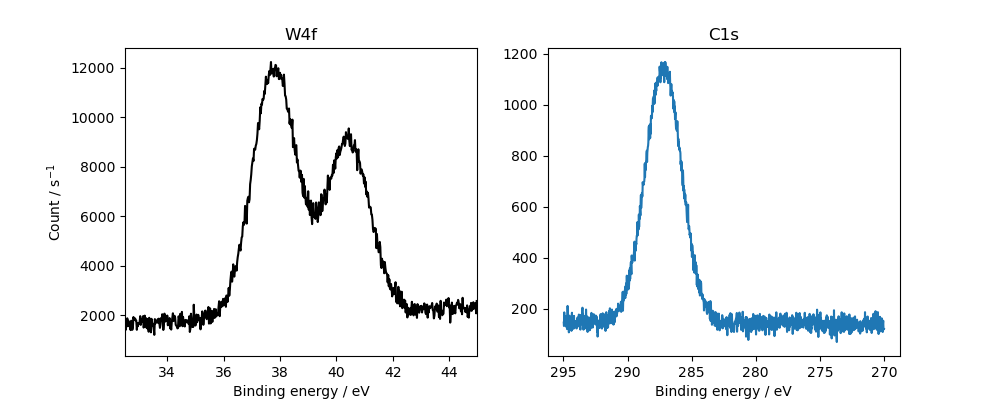

Text(0.5, 1.0, 'C1s')

In [39]:
# Import the data

W4f = pd.read_csv("Tungsten_4f_spectrum.txt",delimiter=" ")
C1s = pd.read_csv("Carbon_1s_spectrum.txt",delimiter=" ")

# Create interactive plots of the data
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,4));
ax1.plot(W4f.iloc[:,0],W4f.iloc[:,1],"k-");
ax2.plot(C1s.iloc[:,0],C1s.iloc[:,1]);

ax1.set_xlabel("Binding energy / eV")
ax1.invert_xaxis()
ax1.set_title("W4f")
ax1.set_ylabel("Count / s$^{-1}$");
ax1.set_xlim([32.5,45])

ax2.set_xlabel("Binding energy / eV")
ax2.invert_xaxis()
ax2.set_title("C1s")
ax2.set_xlim([280,295])

<div class="alert alert-success" style="font-size: 16px;"> 
    <b>Task 1:</b>  <b> Identify the peaks in the W4f spectrum. </b> <br> <br>Consider the chemical composition of Na$_2$WO$_{4}$, together with the NIST database of reference spectra (<A Href="https://srdata.nist.gov/xps/ElmComposition">here</A>)

<div class="alert alert-success" style="font-size: 16px;"> 
<b>Task 2:</b>  <b> Evaluate the peak positions in terms of binding energy for the W4f and C1s spectra.</b><br>  <br> You can either use the marker feature of the interactive plot (values displayed to the bottom right) or, if you are feeling more rigorous, by a peak fitting process of your choice.
</div>

## 4. Binding energy scale calibration <a id="0"></a> 

### A. Theory (refresher from experimental practical)

XPS measurements are made in terms of the kinetic energy of the photo-emitted electron. Conversions to binding energy follow the relation

$$
E_k = h\nu - E_b - \Phi
$$

where $E_k$ is the measured kinetic energy of the emitted photon, $E_b$ is the binding energy and $\Phi$ is the work function.
Provided that the detector is calibrated and linearity has been tested for, any conductive sample (i.e. metallic) that is electrically connected to it will share the same Fermi level. Under this condition, we can assume that $\Phi$ corresponds to the work function of the detector, which is known.

The situation is more complicated for insulating samples for two reasons.

<b> 1. Different Fermi levels </b> <br>Since insulating samples cannot share the same Fermi level as the detector, $\Phi$ no longer corresponds to the detector work function. (It will be offset by an unknown amount). <br>

<b> 2. Charging </b> <br>Insulating samples will steadily gain a positive charge near its surface since photoemitted electrons cannot be naturally compensated for. This will not only shift (increase) the apparent binding energy, but has also been found to change peak lineshapes in severe instances.

For the above reasons, the measurement of insulating samples requires careful case-by-case calibration. 

### B. C1s calibration standards

A common calibration standard for insulating samples is to make use of carbon contamination (C1s spectrum) that is frequently deposited as an adlayer on the surface of insulating samples. We will also use this method here. 

While this can work as a reasonable starting point, it is important to note that there are major drawbacks to this approach. This includes:

- The possible presence of C in different oxidation states in adlayer carbon
- Challenges in distinguishing adlayer carbon to sample carbon

For further reading on the use of C1s spectra for calibration, refer especially to <A Href="https://onlinelibrary.wiley.com/doi/full/10.1002/anie.201916000">this paper</A>.


<div class="alert alert-danger" style="font-size: 16px;">
    <b> Important note! </b> <br><br> The calibration method required will not only depend on whether your sample is conductive or not, but also on its chemical composition and the availability of suitable calibration standards. <br><br> 
</div>


The following (simplified!) decision tree indicates what energy calibration process is likely necessary based on certain sample properties. 

<img src="Binding energy calibration flow chart.png" width="800"/>
<br>
<br>
<center> <b> Figure 2 </b> Flowchart for deciding an appropriate binding energy scale calibration method depending on sample requirements.</center> 

### C. Applying offsets to data

<div class="alert alert-success" style="font-size: 16px;"> 
<b>Task 3:</b>  <b> Correct the binding energy scales for both W4f and C1s spectra by evaluating the charging offset the C1s spectrum.</b><br>  <br> Use the NIST database of reference spectra (<A Href="https://srdata.nist.gov/xps/ElmComposition">here</A>). <br> Importantly, make sure to check that the W4f peak positions are in agreement with literature values.
</div>

In [40]:
# Consider offsets

offset = 0.0  # <---- input your calculated charging offset here in eV

corrected_W4f = W4f.iloc[:,0] - offset
corrected_C1s = C1s.iloc[:,0] - offset

<IPython.core.display.Javascript object>


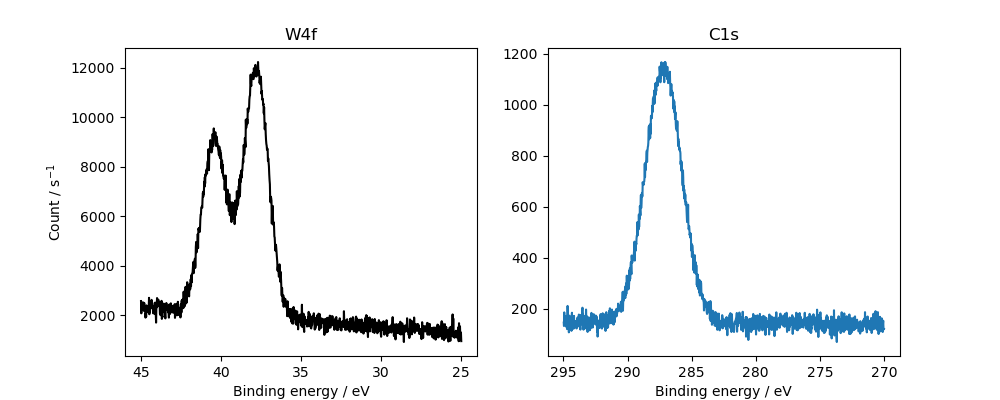

In [41]:
# Plot the data
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,4));
ax1.plot(corrected_W4f,W4f.iloc[:,1],"k-");
ax2.plot(corrected_C1s,C1s.iloc[:,1]);

ax1.set_xlabel("Binding energy / eV")
ax1.invert_xaxis()
ax1.set_title("W4f")
ax2.set_xlabel("Binding energy / eV")
ax2.invert_xaxis()
ax2.set_title("C1s")
ax1.set_ylabel("Count / s$^{-1}$");

## 5. Background treatment<a id="0"></a> 

### A. Types of background

Prior to conducting any fitting of spectrum peaks, we must consider the overlayed background. 


Background signal arises due to photo-emitted electrons from a certain energy level undergoing inelastic scattering as it exits the sample. This typically results in a broad tail at higher binding energies to the main photoemission peak (i.e., lower kinetic energies). 

A full mechanistic understanding of how background signals emerge is still lacking, and as such, there is no analytical model with which backgrounds can be simulated. Therefore, a number of empirical lineshapes are commonly used to estimate the background. These are:

1. Linear
2. Shirley
3. Tougaard

The linear background is self-explanatory (estimates the background with a linear fit). 
The Shirley and Tougaard backgrounds are calculated via an interative algorithm to give a sigmoidal lineshape. 

<div class="alert alert-success" style="font-size: 16px;"> 
<b>Task 4:</b>  <b> Run the following code block and use the interactive plot to see how the different background curves fit to the corrected W4f spectrum.</b>
</div>

C:\Users\ryomi\AppData\Local\Temp\ipykernel_19968\3465734344.py:47: RuntimeWarning: overflow encountered in double_scalars
  y = np.log(integrand_sum / integrand_sum_old) * energy
C:\Users\ryomi\AppData\Local\Temp\ipykernel_19968\3465734344.py:47: RuntimeWarning: divide by zero encountered in log
  y = np.log(integrand_sum / integrand_sum_old) * energy


<IPython.core.display.Javascript object>


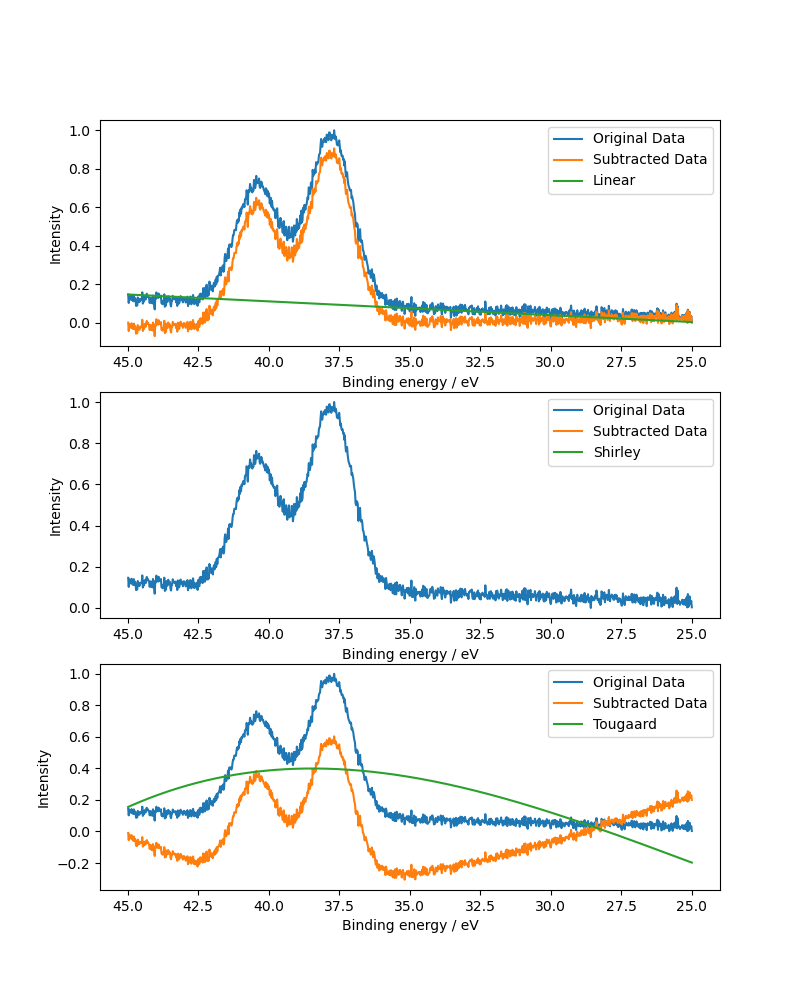

In [49]:
# Input data and normalise
x_data = corrected_W4f
y_data = W4f.iloc[:,1]
min_val = np.min(y_data)
max_val = np.max(y_data)
normalized_data = (y_data - min_val) / (max_val - min_val)


##################### A bunch of functions for background fitting and displaying (NO NEED TO EDIT) #####################
########################################################################################################################

# Function for linear background subtraction
def linear_background(energy, signal):
    X1,Y1 = energy[0],signal.iloc[0]
    X2,Y2 = energy.iloc[-1],signal.iloc[-1]
    slope = (Y2-Y1)/(X2-X1)
    intercept = Y1 - slope*(X1)
    return slope*energy + intercept

# Function for Tougaard background subtraction
def tougaard_background(x, alpha, beta, gamma):
    return alpha * x + beta * x**2 + gamma * x**3

# Residual function for Tougaard background subtraction
def residual_tougaard(params, x, y):
    background = tougaard_background(x, params[0], params[1], params[2])
    return np.sum((y - background)**2)

def shirley_bg_subtraction(energy, signal, num_peaks, max_iterations=10000, tolerance=1e-6):
    n = len(energy)
    y = np.zeros_like(signal)
    y_old = np.zeros_like(signal)

    # Fit the signal with multiple Shirley backgrounds
    for _ in range(num_peaks):
        popt, _ = curve_fit(lambda x, a, b: a * np.exp(b * x), energy, signal - y)
        y += popt[0] * np.exp(popt[1] * energy)

    for _ in range(max_iterations):
        integrand = np.exp((signal - y) / energy)
        integrand_sum = np.trapz(integrand, energy)
        integrand_sum_old = np.trapz(np.exp((signal - y_old) / energy), energy)
        if np.abs(integrand_sum - 1) < tolerance:
            break

        y_old = y.copy()
        y = np.log(integrand_sum / integrand_sum_old) * energy
    return signal-y,y

# Function to perform background subtraction based on the chosen method
def subtract_background(x, y, method, peak_number):
    if method == 'Linear':
        background_curve = linear_background(x,y)
        background_subtracted = y - background_curve
    elif method == 'Shirley':
        background_subtracted, background_curve = shirley_bg_subtraction(x,y, peak_number, max_iterations=1000, tolerance=1e-6)
    elif method == 'Tougaard':
        initial_params = [0.0, 0.0, 0.0]
        result = minimize(residual_tougaard, initial_params, args=(x, y), method='L-BFGS-B')
        optimal_params = result.x
        background_curve = tougaard_background(x, *optimal_params)
        background_subtracted = y - background_curve
    else:
        raise ValueError('Invalid background subtraction method')
    return background_subtracted, background_curve

# Function to update the plot based on user input

background_subtracted1, background_curve1 = subtract_background(x_data, normalized_data, "Linear", 2)
background_subtracted2, background_curve2 = subtract_background(x_data, normalized_data, "Shirley", 2)
background_subtracted3, background_curve3 = subtract_background(x_data, normalized_data, "Tougaard", 2)

fig,(ax1,ax2,ax3) = plt.subplots(3,1,figsize=(8,10))

axes = [ax1,ax2,ax3]
back_subs = [background_subtracted1,background_subtracted2,background_subtracted3]
back_curves = [background_curve1,background_curve2,background_curve3]
names = ["Linear","Shirley","Tougaard"]

for i in range(len(axes)):
    axes[i].plot(x_data, normalized_data, label='Original Data')
    axes[i].plot(x_data, back_subs[i], label='Subtracted Data')
    axes[i].plot(x_data, back_curves[i], label=names[i])
    axes[i].invert_xaxis()
    axes[i].legend()
    axes[i].set_ylabel('Normalised Intensity')
    axes[i].set_xlabel('Binding energy / eV')
    
plt.show()


### B. Conditions for using backgrounds

<div class="alert alert-block alert-danger"> <b>Important note! </b> Incorrect choice and use of background subtraction can significantly alter the lineshape of the actual peaks we wish to analyse. </div>

<div class="alert alert-block alert-danger"> <b>Important note! </b> <br> Noise reduction is commonly used to compensate for poor signal to noise ratios. However, this should be done with care as smoothing can also significantly alter the lineshape of the actual peaks we wish to analyse.  </div>

In [2]:
%load_ext watermark
%watermark -v -m -p pandas,numpy,matplotlib,scipy,ipywidgets

Python implementation: CPython
Python version       : 3.9.13
IPython version      : 7.31.1

pandas    : 1.4.4
numpy     : 1.21.5
matplotlib: 3.5.2
scipy     : 1.9.3
ipywidgets: 8.1.1

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 154 Stepping 3, GenuineIntel
CPU cores   : 20
Architecture: 64bit

